---
# <CENTER><font color="indigo">GridSearch for Optimal Hyperparameter Tuning in CNN-based Image Classification
---
    
    
<br>Based on **https://medium.com/@kylepob61392/airplane-image-classification-using-a-keras-cnn-22be506fdb53**

Σκοπός της εργασίας είναι η υλοποίηση ενός ταξινομητή εικόνων για τον εντοπισμό αεροπλάνων. 
Πραγματοποιείται βελτιστοποίηση των ακόλουθων υπερπαραμέτρων με τη μέθοδο _GridSearch_: 

* **learning rate → [0.001, 0.01, 0.1]**
* **activation functions → [relu, tanh, sigmoid]**
* **optimizers → [Adam, Nadam, SGD]**



## ΕΙΣΑΓΩΓΗ ΒΙΒΛΙΟΘΗΚΩΝ 
Ο κώδικας ξεκινά με τις απαραίτητες εισαγωγές για εργασίες προεπεξεργασίας δεδομένων και μηχανικής εκμάθησης. Οι απαιτούμενες βιβλιοθήκες περιλαμβάνουν _glob, numpy, os.path, matplotlib.pyplot, imageio, keras και sklearn_.

In [47]:
# -*- coding: utf-8 -*-
## DATA PREPROCESSING ##
# Imports
import glob
import numpy as np
import os.path as path
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import tensorflow as tf
from sklearn.model_selection import cross_validate, KFold

# Imports for ML
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, Nadam, SGD
from sklearn.model_selection import GridSearchCV

## ΠΡΟΕΠΕΡΓΑΣΙΑ ΔΕΔΟΜΕΝΩΝ

* Το σύνολο δεδομένων _planesnet_ χρησιμοποιείται για ταξινόμηση εικόνων. Τα αρχεία εικόνας αποθηκεύονται στον καθορισμένο κατάλογο και οι διαδρομές τους αποθηκεύονται στη λίστα *file_paths*.
* Οι εικόνες φορτώνονται χρησιμοποιώντας τη βιβλιοθήκη _imageio_ και αποθηκεύονται ως _numpy array_.
* Το μέγεθος των εικόνων καθορίζεται και εκτυπώνεται για να παρέχει μια επισκόπηση των δεδομένων.

In [4]:
# IMAGE_PATH should be the path to the planesnet folder
IMAGE_PATH = r'C:\Users\Admin\Downloads\bigdata\2ndAssignment\planesnet'
file_paths = glob.glob(path.join(IMAGE_PATH, '*.png'))

# Load the images
images = [imageio.imread(i_path) for i_path in file_paths]
images = np.asarray(images)

# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

# Scale
images = images / 255

# Read the labels from the filenames
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

[20 20  3]


* Οι εικόνες κλιμακώνονται διαιρώντας τις με 255 για να ομαλοποιηθούν οι τιμές των εικονοστοιχείων.
* Οι ετικέτες για τις εικόνες εξάγονται από τα ονόματα αρχείων και αποθηκεύονται στον πίνακα _labels_.
* Το σύνολο δεδομένων χωρίζεται σε σύνολα εκπαίδευσης και δοκιμών χρησιμοποιώντας την αναλογία *TRAIN_TEST_SPLIT*. Οι δείκτες ανακατεύονται τυχαία και ο διαχωρισμός εκτελείται με βάση τους ανακατεμένους δείκτες.
* Τα σετ εκπαίδευσης και δοκιμών δημιουργούνται χρησιμοποιώντας τους ανακατεμένους δείκτες και τις αντίστοιχες εικόνες και ετικέτες.

In [5]:
#%% Split into test and training sets
TRAIN_TEST_SPLIT = 0.75

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :, :]
y_test = labels[test_indices]


## ΟΠΤΙΚΟΠΟΙΗΣΗ ΔΕΔΟΜΕΝΩΝ

* Ορίζεται η συνάρτηση **visualize_data()** για την οπτικοποίηση ενός υποσυνόλου θετικών και αρνητικών παραδειγμάτων από το σετ εκπαίδευσης.
* Εάν η σημαία **VISUALIZE_DATA** έχει οριστεί σε **True**, η συνάρτηση καλείται για να εμφανίσει τα επιλεγμένα θετικά και αρνητικά παραδείγματα.
* Η οπτικοποίηση περιλαμβάνει θετικά παραδείγματα με την ένδειξη "1" και αρνητικά παραδείγματα με την ένδειξη "0".
* Ο αριθμός των θετικών και αρνητικών παραδειγμάτων προς εμφάνιση μπορεί να προσαρμοστεί τροποποιώντας την παράμετρο **N_TO_VISUALIZE**.
* Τα θετικά και αρνητικά παραδείγματα εξάγονται από το σετ εκπαίδευσης με βάση τις ετικέτες τους και εμφανίζονται χρησιμοποιώντας το _matplotlib_.

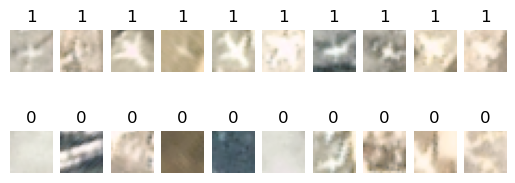

In [6]:
#%% DATA VISUALIZATION ##
# Define data visualization function
VISUALIZE_DATA = True
if VISUALIZE_DATA:

    def visualize_data(positive_images, negative_images):
        # INPUTS
        # positive_images - Images where the label = 1 (True)
        # negative_images - Images where the label = 0 (False)

        figure = plt.figure()
        count = 0
        for i in range(positive_images.shape[0]):
            count += 1
            figure.add_subplot(2, positive_images.shape[0], count)
            plt.imshow(positive_images[i, :, :])
            plt.axis('off')
            plt.title("1")

            figure.add_subplot(1, negative_images.shape[0], count)
            plt.imshow(negative_images[i, :, :])
            plt.axis('off')
            plt.title("0")
        plt.show()


    # Number of positive and negative examples to show
    N_TO_VISUALIZE = 10

    # Select the first N positive examples
    positive_example_indices = (y_train == 1)
    positive_examples = x_train[positive_example_indices, :, :]
    positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

    # Select the first N negative examples
    negative_example_indices = (y_train == 0)
    negative_examples = x_train[negative_example_indices, :, :]
    negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

    # Call the visualization function
    visualize_data(positive_examples, negative_examples)


## ΔΗΜΙΟΥΡΓΙΑ ΜΟΝΤΕΛΟΥ
* Ο κώδικας προχωρά στον καθορισμό των υπερπαραμέτρων και της αρχιτεκτονικής του μοντέλου για το CNN.
* Οι υπερπαράμετροι περιλαμβάνουν τον αριθμό των επιπέδων **N_LAYERS, learning_rates, activations και optimizers**.
* Ορίζεται η **create_model()** για τη δημιουργία του μοντέλου CNN χρησιμοποιώντας τις καθορισμένες υπερπαραμέτρους.
* Το μοντέλο αποτελείται από _συνελικτικά στρώματα, max pooling, flattening_ και ένα _dense στρώμα για δυαδική ταξινόμηση_.
* Το μοντέλο συντάσσεται με τη συνάρτηση απώλειας _δυαδικής διασταυρούμενης εντροπίας_ και τον καθορισμένο βελτιστοποιητή και ρυθμό εκμάθησης.
* Το _KerasClassifier_ χρησιμοποιείται για τη δημιουργία ενός μοντέλου συμβατό με το _scikit-learn_.
* Το __early stopping__ ορίζεται για την παρακολούθηση της απώλειας επικύρωσης και τη διακοπή της εκμάθησης εάν δεν βελτιωθεί για συγκεκριμένο αριθμό εποχών.

In [7]:
#%%# MODEL CREATION ##
# Model Hyperparamaters
N_LAYERS = 4

learning_rates = [0.001, 0.01, 0.1]
activations = ['relu', 'tanh', 'sigmoid']
optimizers = [Adam, Nadam, SGD]

def create_model(learning_rate, activation, optimizer):
    # Create a CNN model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=image_size))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

# Create the parameter grid
# Create the parameter grid
param_grid = {
    'learning_rate': learning_rates,
    'activation': activations,
    'optimizer': optimizers
}

# Create the model
model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=200, verbose=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_4172\658781275.py:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=200, verbose=1)


To callback του _TensorBoard_ έχει ρυθμιστεί για να καταγράφει τη διαδικασία εκπαίδευσης για οπτικοποίηση και τα callbacks αποθηκεύονται σε μια λίστα.

In [71]:
#%% TensorBoard callback
LOG_DIRECTORY_ROOT = 'logdir'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

# Place the callbacks in a list
callbacks = [early_stopping, tensorboard]

In [72]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [73]:
%tensorboard --logdir LOG_DIRECTORY_ROOT

Reusing TensorBoard on port 6006 (pid 13148), started 5 days, 3:57:25 ago. (Use '!kill 13148' to kill it.)

In [74]:
%tensorboard --inspect --logdir LOG_DIRECTORY_ROOT

ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stdout:
Processing event files... (this can take a few minutes)

No event files found within logdir LOG_DIRECTORY_ROOT

* Το _πλέγμα παραμέτρων_ ορίζεται χρησιμοποιώντας τους ρυθμούς εκμάθησης, τις ενεργοποιήσεις και τους βελτιστοποιητές.
* Το μοντέλο _KerasClassifier, το πλέγμα παραμέτρων και τα callbacks_ μεταβιβάζονται στη συνάρτηση **GridSearchCV** για tuning των υπερπαραμέτρων.
* Η αναζήτηση πλέγματος πραγματοποιείται με _5-fold cross-validation_ στο σετ εκπαίδευσης.
* Το καλύτερο μοντέλο και οι καλύτερες παράμετροί του λαμβάνονται από τα αποτελέσματα αναζήτησης πλέγματος.

In [12]:
#%% Perform GridSearchCV
%%capture
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=['accuracy', 'f1_weighted'], refit='accuracy', cv=5)
grid_result = grid.fit(x_train, y_train)

# Get the best model
best_model = grid_result.best_estimator_

# Get the best parameter combination
best_params = grid_result.best_params_

# Evaluate the best model on the test set
test_predictions = best_model.predict(x_test)
test_predictions = np.round(test_predictions)

# Report the accuracy and F1-score
accuracy = accuracy_score(y_test, test_predictions)
f1Score = f1_score(y_test, test_predictions, average='weighted')

Epoch 1/3
96/96 [==============================] - 6s 38ms/step - loss: 0.4536 - accuracy: 0.7627
Epoch 2/3
96/96 [==============================] - 4s 40ms/step - loss: 0.3360 - accuracy: 0.8384
Epoch 3/3
150/150 [==============================] - 1s 4ms/step
Epoch 1/3
96/96 [==============================] - 5s 37ms/step - loss: 3.8337 - accuracy: 0.7515
Epoch 2/3
96/96 [==============================] - 4s 39ms/step - loss: 3.8337 - accuracy: 0.7515
Epoch 3/3
150/150 [==============================] - 1s 6ms/step
Epoch 1/3
96/96 [==============================] - 6s 42ms/step - loss: 0.5730 - accuracy: 0.7252
Epoch 2/3
96/96 [==============================] - 3s 35ms/step - loss: 0.4359 - accuracy: 0.7578
Epoch 3/3
150/150 [==============================] - 1s 5ms/step
Epoch 1/3
96/96 [==============================] - 7s 35ms/step - loss: 0.6068 - accuracy: 0.7113
Epoch 2/3
96/96 [==============================] - 3s 28ms/step - loss: 0.4823 - accuracy: 0.7300
Epoch 3/3
150/150 [==

## ΚΑΛΥΤΕΡΟ ΜΟΝΤΕΛΟ

In [16]:
print("Best Model based on Accuracy and F1-score:")
best_model.model.summary()
print("Best Parameters: ", best_params)
print("Accuracy: " + str(accuracy))
print("F1-score: " + str(f1Score))



# Visualize the results of the best model based on F1-score
best_model_predictions = best_model.predict(x_test)
best_model_predictions = np.round(best_model_predictions)

Best Model based on Accuracy and F1-score:
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 18, 18, 32)        896       
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 9, 9, 32)         0         
 ng2D)                                                           
                                                                 
 flatten_135 (Flatten)       (None, 2592)              0         
                                                                 
 dense_135 (Dense)           (None, 1)                 2593      
                                                                 
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
_________________________________________________________________
Best Parameters:  {'activation': 'relu', 'learning_rate': 0.001, 'optimiz

## ΠΑΡΑΤΗΡΗΣΕΙΣ
Εν συγκρίσει με τον αρχικό κώδικα παρατηρούμε ότι: 
* ο χρόνος διεκπαιρέωσης μιας εποχής έχει μειωθεί σημαντικά κατά **91%** (από ~104s -> ~9s) πράγμα που διαφαίνεται και στον μικρότερο αριθμό Total parameters του τελικού μοντέλου που έχουν υποστεί σημαντική μείωση χάριν υπολογιστικής απλότητας (489597 -> 3489 )

## ΟΠΤΙΚΟΠΟΙΗΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

* Εάν η σημαία **VISUALIZE_RESULTS** έχει οριστεί σε **True**, ορίζονται δύο συναρτήσεις για την απεικόνιση των εσφαλμένων ετικετών εικόνων στο δοκιμαστικό σύνολο.
* Η συνάρτηση **visualize_incorrect_labels**, λαμβάνει το σύνολο δοκιμής, τις αληθινές ετικέτες και τις προβλεπόμενες ετικέτες ως εισόδους.
* Επιλέγει ένα υποσύνολο εικόνων με εσφαλμένη σήμανση και τις εμφανίζει μαζί με τις προβλεπόμενες και αληθινές ετικέτες τους.
* Η συνάρτηση καλείται δύο φορές, μία για τις αρχικές προβλέψεις δοκιμής και μία για τις προβλέψεις του καλύτερου μοντέλου.

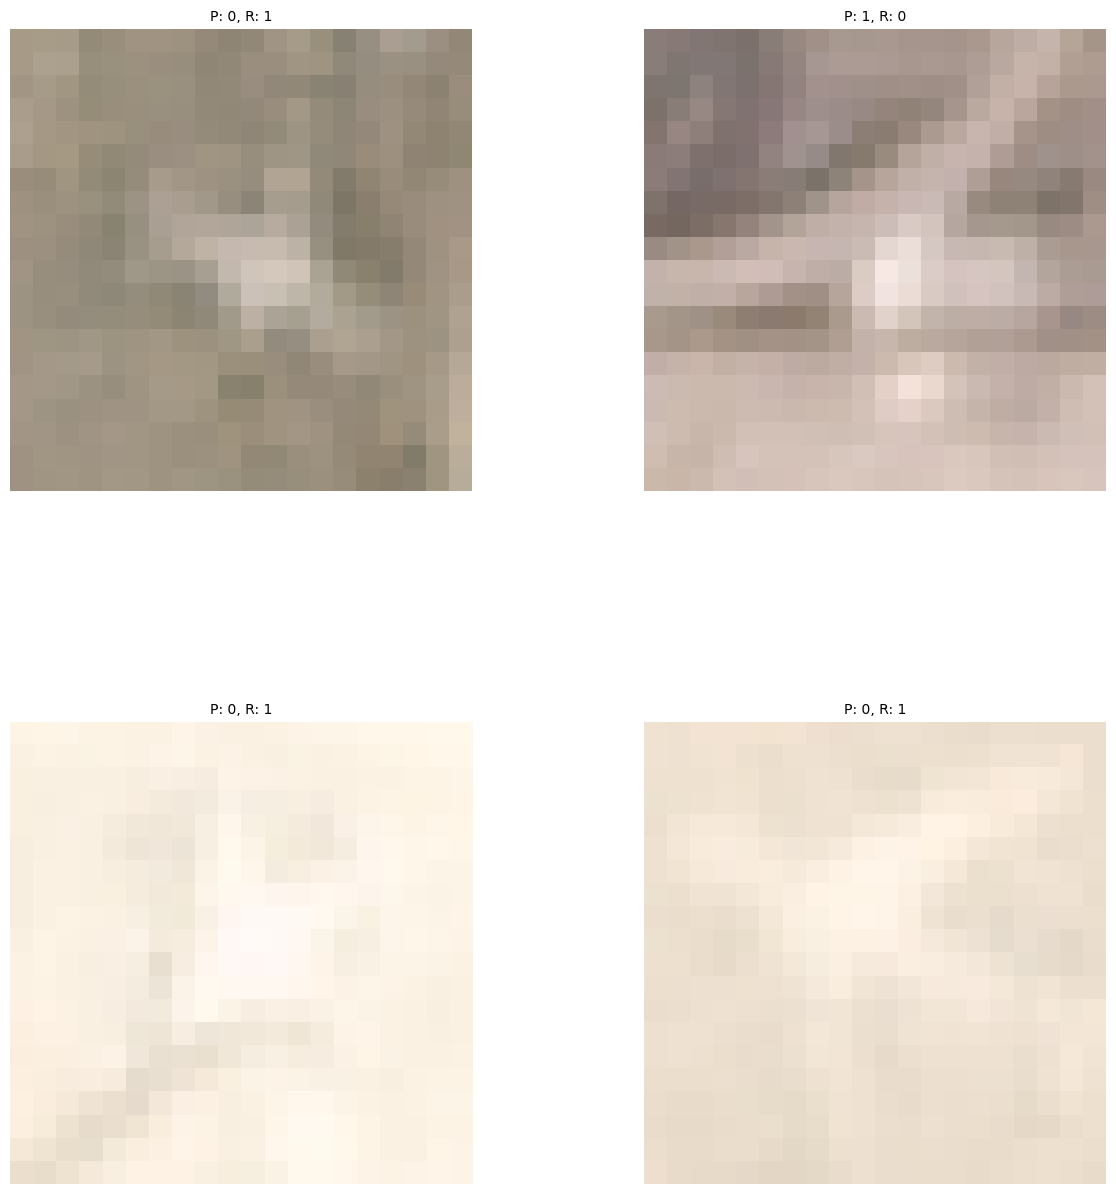

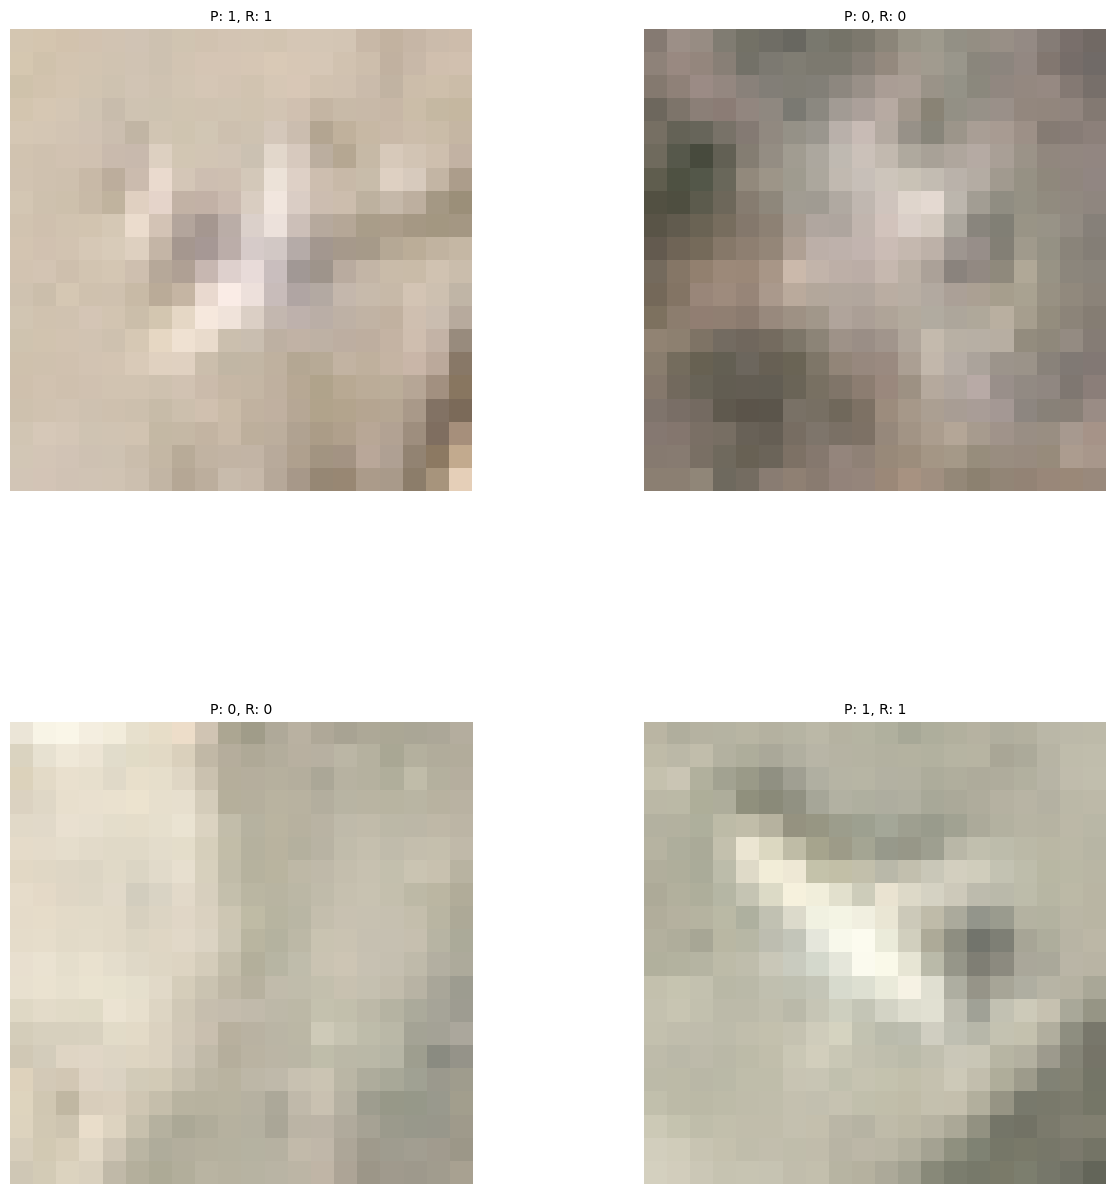

In [77]:
    
VISUALIZE_RESULTS = True
if VISUALIZE_RESULTS:
   def visualize_incorrect_labels(x_data, y_real, y_predicted, n_images=8):
    # INPUTS
    # x_data      - images
    # y_real      - ground truth labels
    # y_predicted - predicted labels
    incorrect_label_indices = np.where(y_real != y_predicted)[0]
    np.random.shuffle(incorrect_label_indices)
    incorrect_label_indices = incorrect_label_indices[:n_images]
    y_real = np.asarray(y_real)[incorrect_label_indices]
    y_predicted = np.asarray(y_predicted)[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices]

    maximum_square = int(np.ceil(np.sqrt(n_images)))

    fig, axes = plt.subplots(maximum_square, maximum_square, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(x_data[i])
        ax.axis('off')
        ax.set_title("P: " + str(int(y_predicted[i])) + ", R: " + str(int(y_real[i])), fontsize=10)

    plt.show()

   visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel(), n_images=4)
   visualize_incorrect_labels(x_test, y_test, best_model_predictions, n_images=4)



   